Angles in degrees: 0.0 ; Error : ± 5.177329474073704
Angles in degrees: 27.71300000100252 ; Error : ± 5.393024251608468
Angles in degrees: 41.910843624663464 ; Error : ± 5.159457790913707
Angles in degrees: 50.19442890773481 ; Error : ± 4.744615018828704
Countrate position 0 :  0.05434782608695652 ; Error : ± 0.008001069738658668
Countrate position 1 :  0.0502096241805071 ; Error : ± 0.007098420190390901
Countrate position 2 :  0.02462998507144114 ; Error : ± 0.005319718852511826
Countrate position 3 :  0.017730731810900607 ; Error : ± 0.00434339270378391


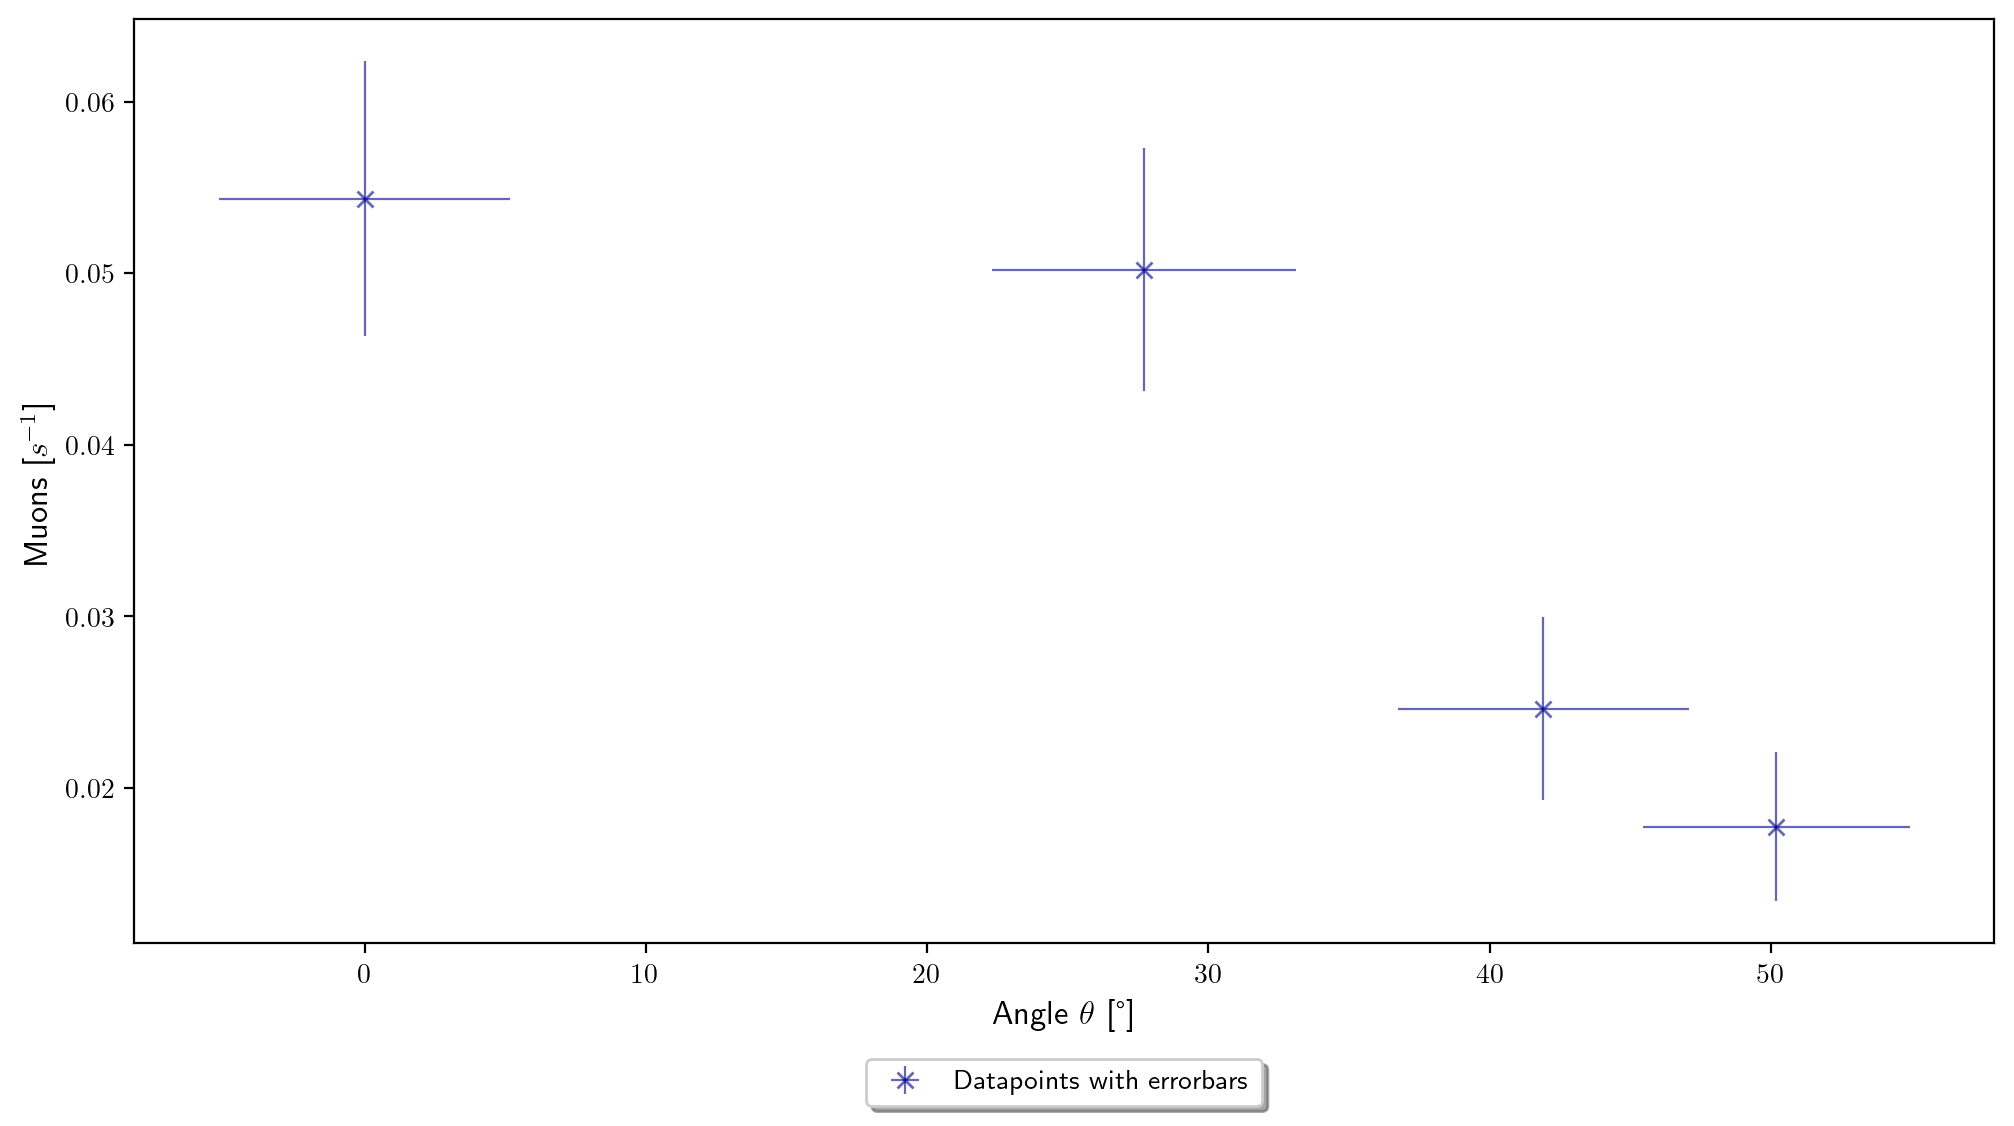

In [31]:
# Auswertung Cherenkov --- Reto N. --- 31.10.2025

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import configparser
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
from scipy.constants import e, c, h, nano
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from scipy.optimize import curve_fit
from scipy.special import wofz

plt.rcParams['text.usetex'] = True #LaTeX

#####
# Subtask 3: Angular Dependence of Cosmic Rays
#####
# Part 1: Calculate the actually measured muon rate for each angle setting and estimate the error on the measurement
#####

#Dimensions of the experiment
radius = 0.15 
tankheight = 0.25                                                                                               #Radius of container in m
height = 1.66                                                                                                   #Vertical distance between containers in m
counts = [52,54,34,24]                                                                                          #Raw counts of events N
wrongcounts = [3,2,7,4]                                                                                         #Counts that were wrong, not muons
duration = [901.6,899.88,900.14,899.92]                                                                         #Durations of the test runs in seconds
durationerr = [0.5,0.5,0.5,0.5]                                                                                         #Duration errors in s
counterr = [np.sqrt(counts[0]),np.sqrt(counts[1]),np.sqrt(counts[2]),np.sqrt(counts[3])]                        #Counting errors, poisson distrib.
disterr = 0.15                                                                                                  #Distance error in m (radius of container)
heighterr = 0.25                                                                                                #Height error in m (height of container)

#Calculation of the angles (in degr, also error of degr for errorbars) between the measurements by means of trigonometry

d0 = 0                                          #d0, d1, d2, d3 ... shift of the container between each measurement
d1 = 2*radius + 0.572
d2 = 2*radius + 0.572 + 2*radius + 0.318
d3 = 2*radius + 0.572 + 2*radius + 0.318 + 2*radius + 0.202

distances = [d0,d1,d2,d3]

distanceserr = [0,0,0,0]
angledegr = [0,0,0,0]
angledegrerror = [0,0,0,0]

for i in range(0, len(distances)): 
    distanceserr[i] = disterr
    angledegr[i] = 90*2/np.pi*np.arctan(distances[i]/height)
    angledegrerror[i] = np.sqrt(distanceserr[i]**2*(90*2/np.pi*(height)/(height**2+distances[i]**2))**2 + (heighterr*90*2/np.pi*(distances[i])/(height**2+distances[i]**2))**2)
    print('Angles in degrees:', angledegr[i], '; Error : ±', angledegrerror[i])
   
#Correction of counts by wrong counts, calculation of countrate and error

countrate = [0,0,0,0]
countrateerr = [0,0,0,0]  
areanormalization = [(np.pi*radius**2)/(np.pi*radius**2),((np.cos(angledegr[1]/180)*np.pi*radius**2)+(np.sin(angledegr[1]/180)*2*radius*tankheight))/(np.pi*radius**2), ((np.cos(angledegr[2]/180)*np.pi*radius**2)+(np.sin(angledegr[2]/180)*2*radius*tankheight))/(np.pi*radius**2),((np.cos(angledegr[3]/180)*np.pi*radius**2)+(np.sin(angledegr[3]/180)*2*radius*tankheight))/(np.pi*radius**2)]

for i in range(0, len(counts)):                                 
    countrate[i] = (counts[i] - wrongcounts[i])/(duration[i]*areanormalization[i])
    countrateerr[i] = np.sqrt((counterr[i]**2)*(1/(areanormalization[i]*duration[i])**2+(durationerr[i]**2)*((counts[i]-wrongcounts[i])/((areanormalization[i]*duration[i]**2)))**2))
    print('Countrate position',i,': ', countrate[i],'; Error : ±', countrateerr[i])
countrate = np.array(countrate)
countraterr = np.array(countrateerr)

fig = plt.figure(figsize=(12, 6), dpi=200)
plt.errorbar(angledegr,countrate,countrateerr,angledegrerror, fmt='x', color='darkblue', alpha=0.6, linewidth=0.8,label="Data")
plt.xlabel(r"Angle $\theta$ [°]", fontsize=12)
plt.ylabel(r"Muons [$s^{-1}$]", fontsize=12)
plt.legend(['Datapoints with errorbars'],loc='upper center', bbox_to_anchor=(0.5, -0.11),
           fancybox=True, shadow=True)
#plt.savefig("Subtask3_measuredrate.pdf")
#plt.savefig("Aufgabe3.pdf", dpi=600, bbox_inches="tight")
plt.show()

a = 0.07650770071689755 ± 0.5310870459914195 , b = 1.23448789137031 ± 4.801479897235619 , c = 0.019186173124487754 ± 0.5359773395618437
[-0.0029737   0.00612629 -0.00356143  0.00095677]
nu 1
chi2 0.8238475102835187
chi2_red 0.8238475102835187


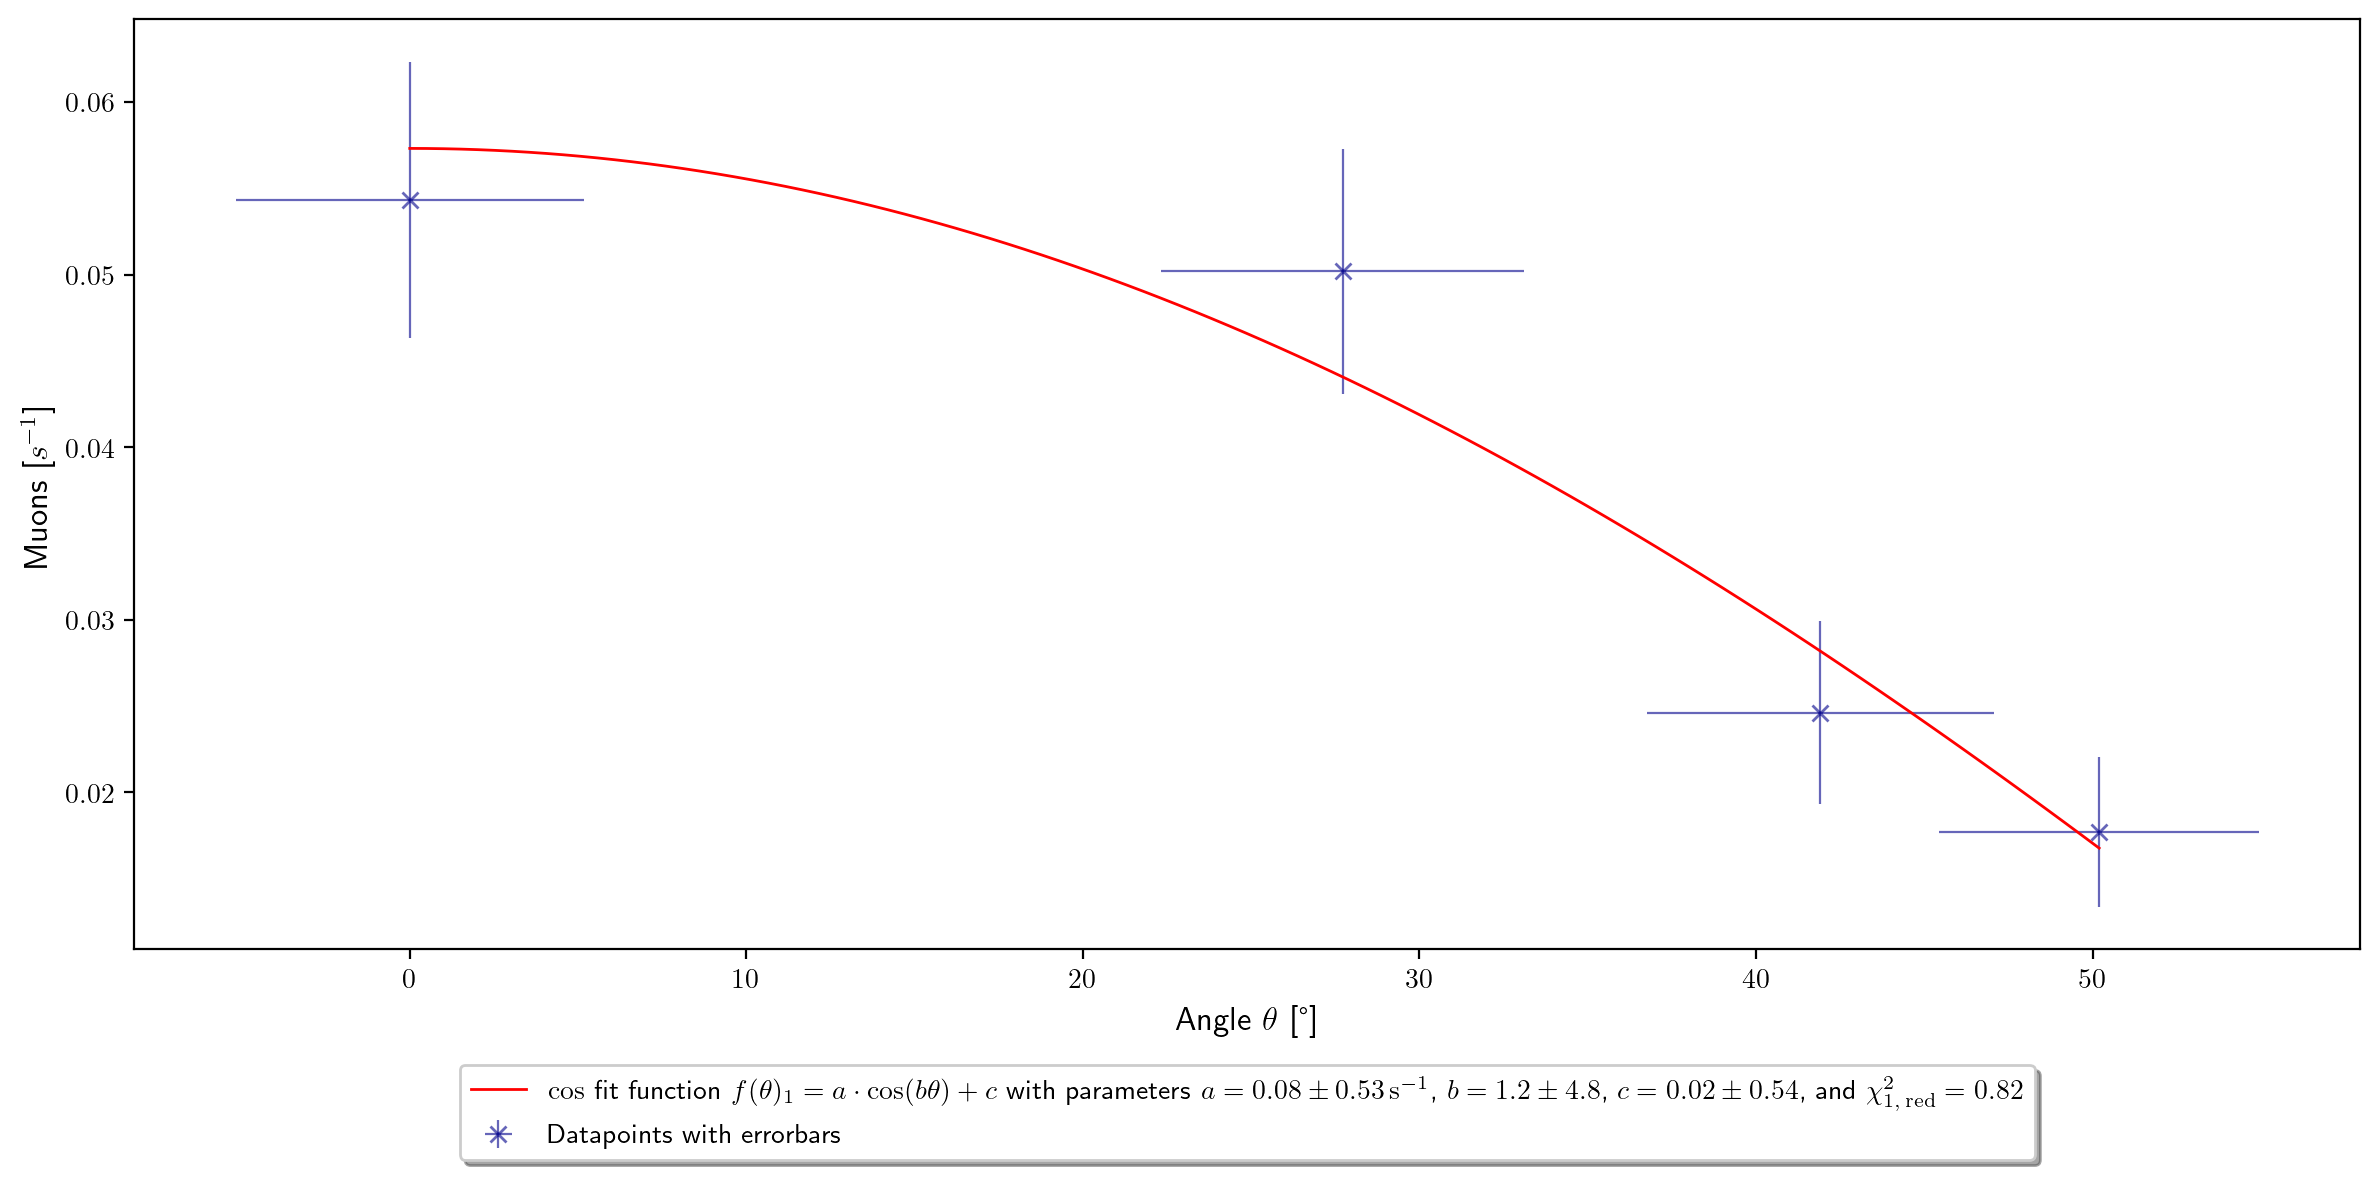

In [32]:
#####
# Part 2: Display results graphically, discuss observed trend and compare with theroetical expectation.
#####

#Fit with a*np.cos(b*x)+c:

def model_f(x,a,b,c):
    return a*np.cos(np.pi*b*x/180)-c

# a is: Initial rate, b is: Scaling, c is: Offset

popt, pcov = curve_fit(model_f, angledegr, countrate, sigma = countrateerr, p0=[0.05,1,0], maxfev=16000)
perr = np.sqrt(np.diag(pcov))

a_opt, b_opt, c_opt = popt
x_model = np.linspace(min(angledegr), max(angledegr), 100)
y_model = model_f(x_model, a_opt, b_opt, c_opt)

print('a =',a_opt,'±',np.sqrt(pcov[0,0]),', b =',b_opt,'±',np.sqrt(pcov[1,1]),', c =',c_opt,'±',np.sqrt(pcov[2,2]))

#Calculating chi2

N = len(countrate)
k = len(popt)
nu = N - k

angledegr = np.array(angledegr)
countrate = np.array(countrate)
angledegrerror = np.array(angledegrerror)
countrateerr = np.array(countrateerr)

dydx = -a_opt * (np.pi*b_opt / 180) * np.sin(np.pi*b_opt * angledegr / 180)
sigma = np.sqrt(countrateerr**2 + (dydx**2) * angledegrerror**2)

chi2 = np.sum(((countrate - model_f(angledegr,*popt)) / sigma)**2)
print((countrate - model_f(angledegr,*popt)))
chi2_red = chi2 / nu
print('nu', nu)
print('chi2',chi2)
print('chi2_red',chi2_red)

#Plot of the values as errorbar, with fit function

fig = plt.figure(figsize=(12, 6), dpi=200)
plt.errorbar(angledegr,countrate,countrateerr,angledegrerror, fmt='x', color='darkblue', alpha=0.6, linewidth=0.8,label="Data")
plt.plot(x_model,y_model,'-', color='red', lw=1.0,)
plt.xlabel(r"Angle $\theta$ [°]", fontsize=12)
plt.ylabel(r"Muons [$s^{-1}$]", fontsize=12)
plt.legend([
    r'$\cos$ fit function $f(\theta)_1 = a \cdot \cos(b \theta) + c$ '
    r'with parameters $a = 0.08 \pm 0.53\,\mathrm{s}^{-1}$, '
    r'$b = 1.2 \pm 4.8$, '
    r'$c = 0.02 \pm 0.54$, '
    r'and $\chi^2_{1,\,\mathrm{red}} = 0.82$',
    'Datapoints with errorbars'
],
loc='upper center', bbox_to_anchor=(0.5, -0.11),
fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("Subtask3_cosfit_measuredrate.pdf")
plt.savefig("Aufgabe3.pdf", dpi=600, bbox_inches = "tight")

C:\Users\Reto Netzer\AppData\Local\Temp\ipykernel_18356\1924718730.py:4: RuntimeWarning: overflow encountered in power
  return a*np.cos(np.pi*b*x/180)**c
C:\Users\Reto Netzer\AppData\Local\Temp\ipykernel_18356\1924718730.py:4: RuntimeWarning: invalid value encountered in power
  return a*np.cos(np.pi*b*x/180)**c


a = 0.056826080029493534 ± 0.0072166635495933135 , b = 1.5767398429880974 ± 0.5319169281683657 , c = 0.7431075644855017 ± 0.9493261646444602
[-0.00247825  0.0055538  -0.00442226  0.00129582]
nu 1
chi2 0.7973675980352105
chi2_red 0.7973675980352105


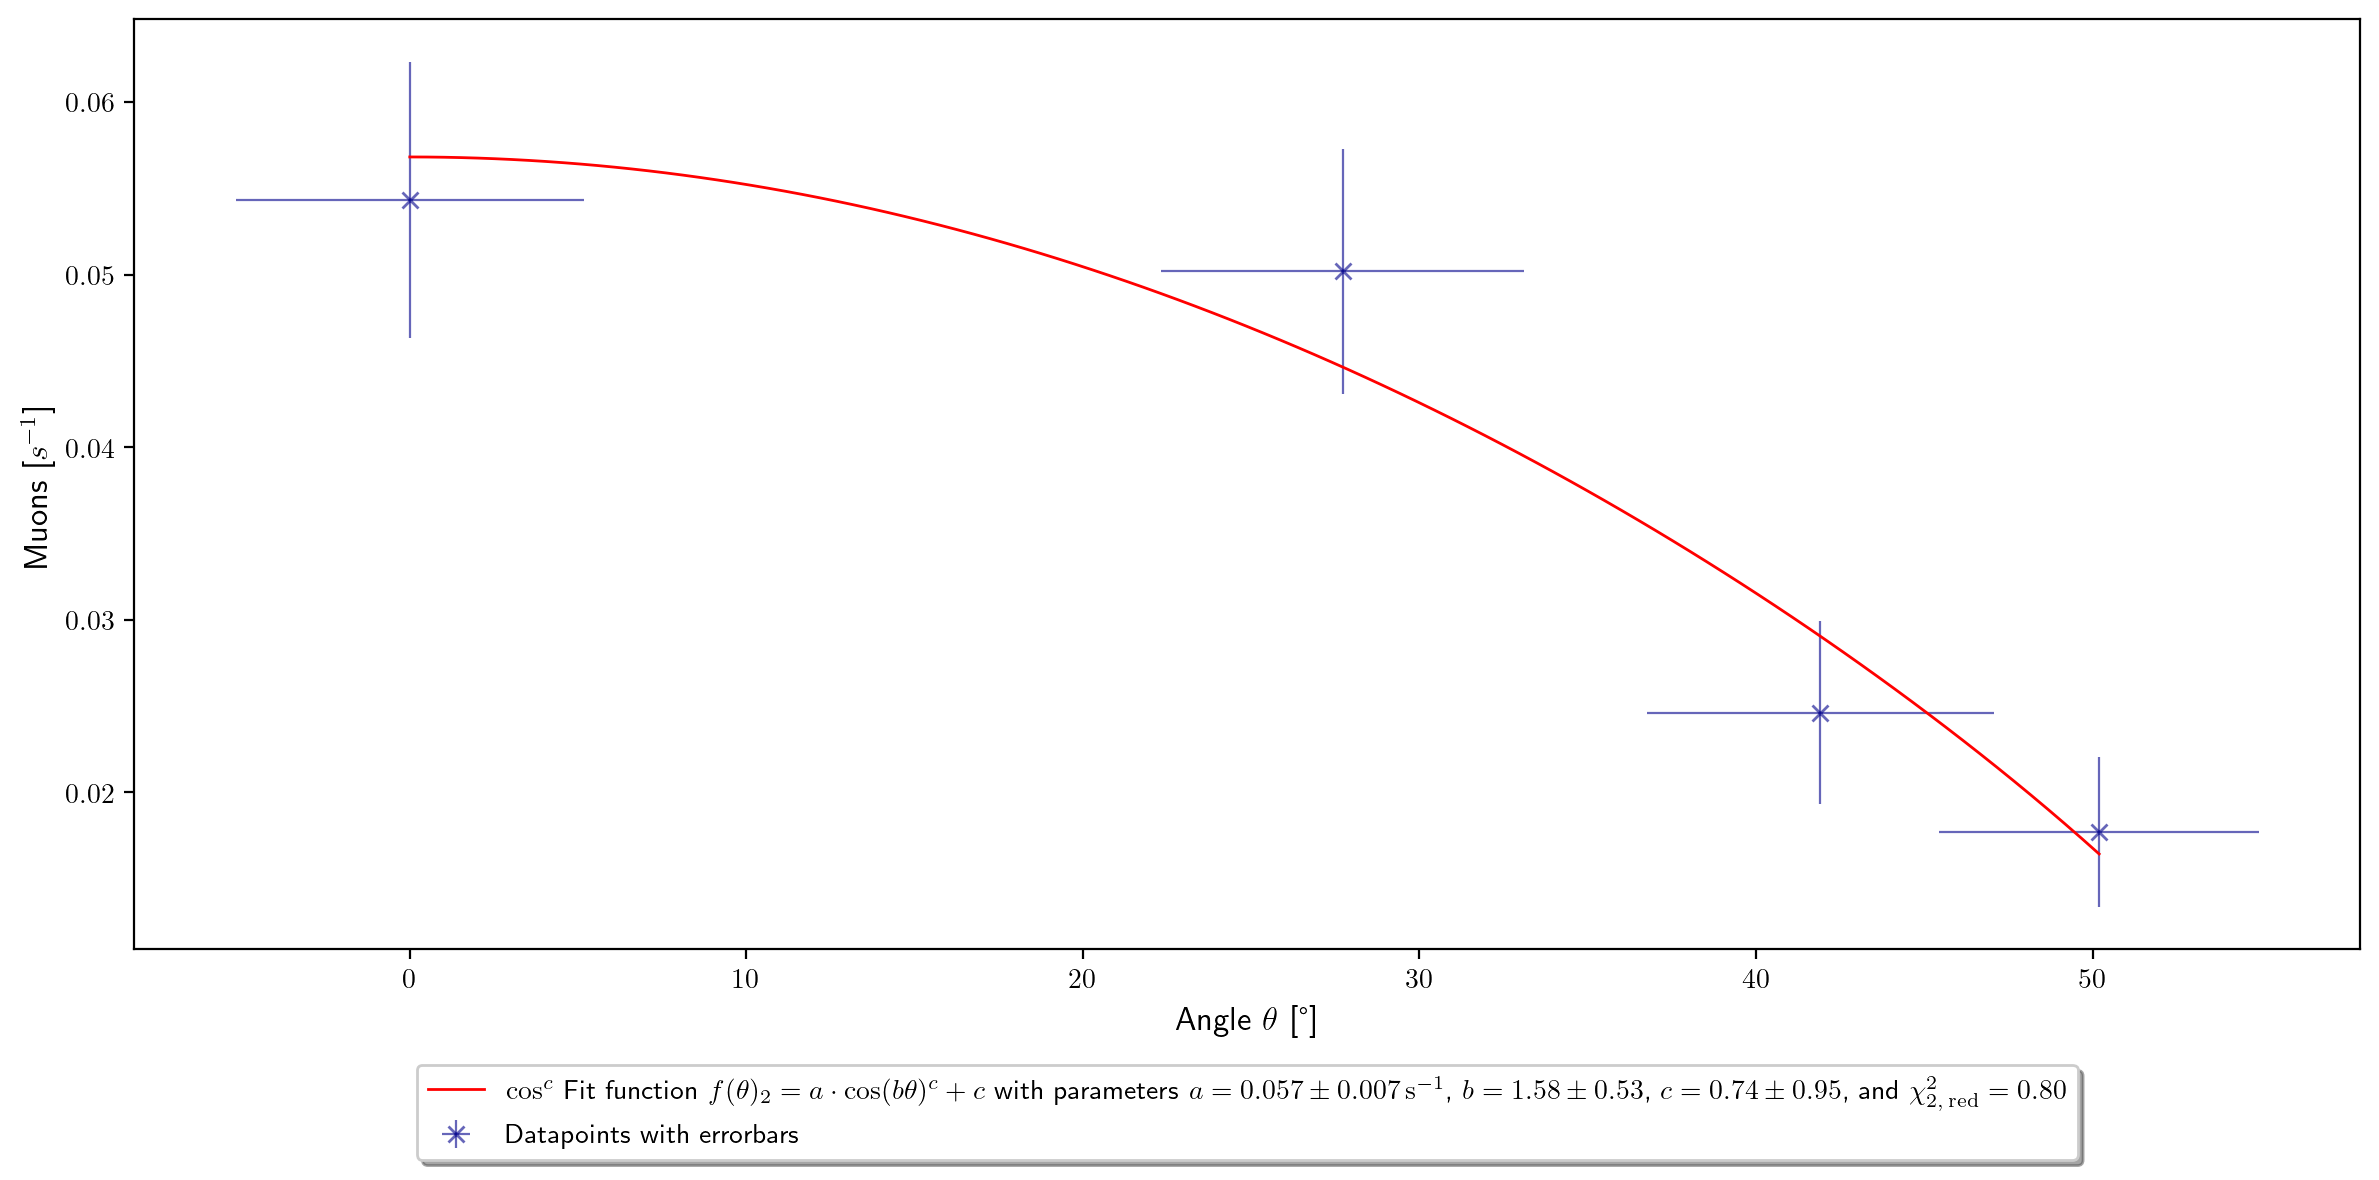

In [33]:
#Fit with a*np.cos(b*x)**c:

def model_f(x,a,b,c):
    return a*np.cos(np.pi*b*x/180)**c

# a is: Initial rate, b is: Scaling, c is: Power

popt, pcov = curve_fit(model_f, angledegr, countrate, p0=[0.05,0.01,1], maxfev=16000)
perr = np.sqrt(np.diag(pcov))

a_opt, b_opt, c_opt = popt
x_model = np.linspace(min(angledegr), max(angledegr), 100)
y_model = model_f(x_model, a_opt, b_opt, c_opt)

print('a =',a_opt,'±',np.sqrt(pcov[0,0]),', b =',b_opt,'±',np.sqrt(pcov[1,1]),', c =',c_opt,'±',np.sqrt(pcov[2,2]))

#Calculating chi2

N = len(countrate)
k = len(popt)
nu = N - k

angledegr = np.array(angledegr)
countrate = np.array(countrate)
angledegrerror = np.array(angledegrerror)
countrateerr = np.array(countrateerr)

dydx = dydx = - (np.pi*a_opt * b_opt * c_opt / 180) * np.cos(np.pi*b_opt * angledegr / 180)**(c_opt - 1) * np.sin(np.pi*b_opt * angledegr / 180)
sigma = np.sqrt(countrateerr**2 + (dydx**2) * angledegrerror**2)

chi2 = np.sum(((countrate - model_f(angledegr,*popt)) / sigma)**2)
print((countrate - model_f(angledegr,*popt)))
chi2_red = chi2 / nu
print('nu', nu)
print('chi2',chi2)
print('chi2_red',chi2_red)

#Plot of the values as errorbar, with fit function

fig = plt.figure(figsize=(12, 6), dpi=200)
plt.errorbar(angledegr,countrate,countrateerr,angledegrerror, fmt='x', color='darkblue', alpha=0.6, linewidth=0.8,label="Data")
plt.plot(x_model,y_model,'-', color='red', lw=1.0,)
plt.xlabel(r"Angle $\theta$ [°]", fontsize=12)
plt.ylabel(r"Muons [$s^{-1}$]", fontsize=12)
plt.legend([
    r'$\cos^c$ Fit function $f(\theta)_2 = a \cdot \cos(b \theta)^c + c$ '
    r'with parameters $a = 0.057 \pm 0.007\,\mathrm{s}^{-1}$, '
    r'$b = 1.58 \pm 0.53$, '
    r'$c = 0.74 \pm 0.95$, '
    r'and $\chi^2_{2,\,\mathrm{red}} = 0.80$',
    'Datapoints with errorbars'
],
loc='upper center', bbox_to_anchor=(0.5, -0.11),
fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("Subtask3_coscfit_measuredrate.pdf")
plt.savefig("Aufgabe3.pdf", dpi=600, bbox_inches = "tight")

a = 0.3911694587387793 ± 1.3578654143694078 , b = 0.6172481342192683 ± 2.400931097301688 , c = -0.09569200584785735 ± 1.0673294676494518
[-0.00297371  0.0061263  -0.00356143  0.00095676]
nu 1
chi2 1.0411637200769734
chi2_red 1.0411637200769734


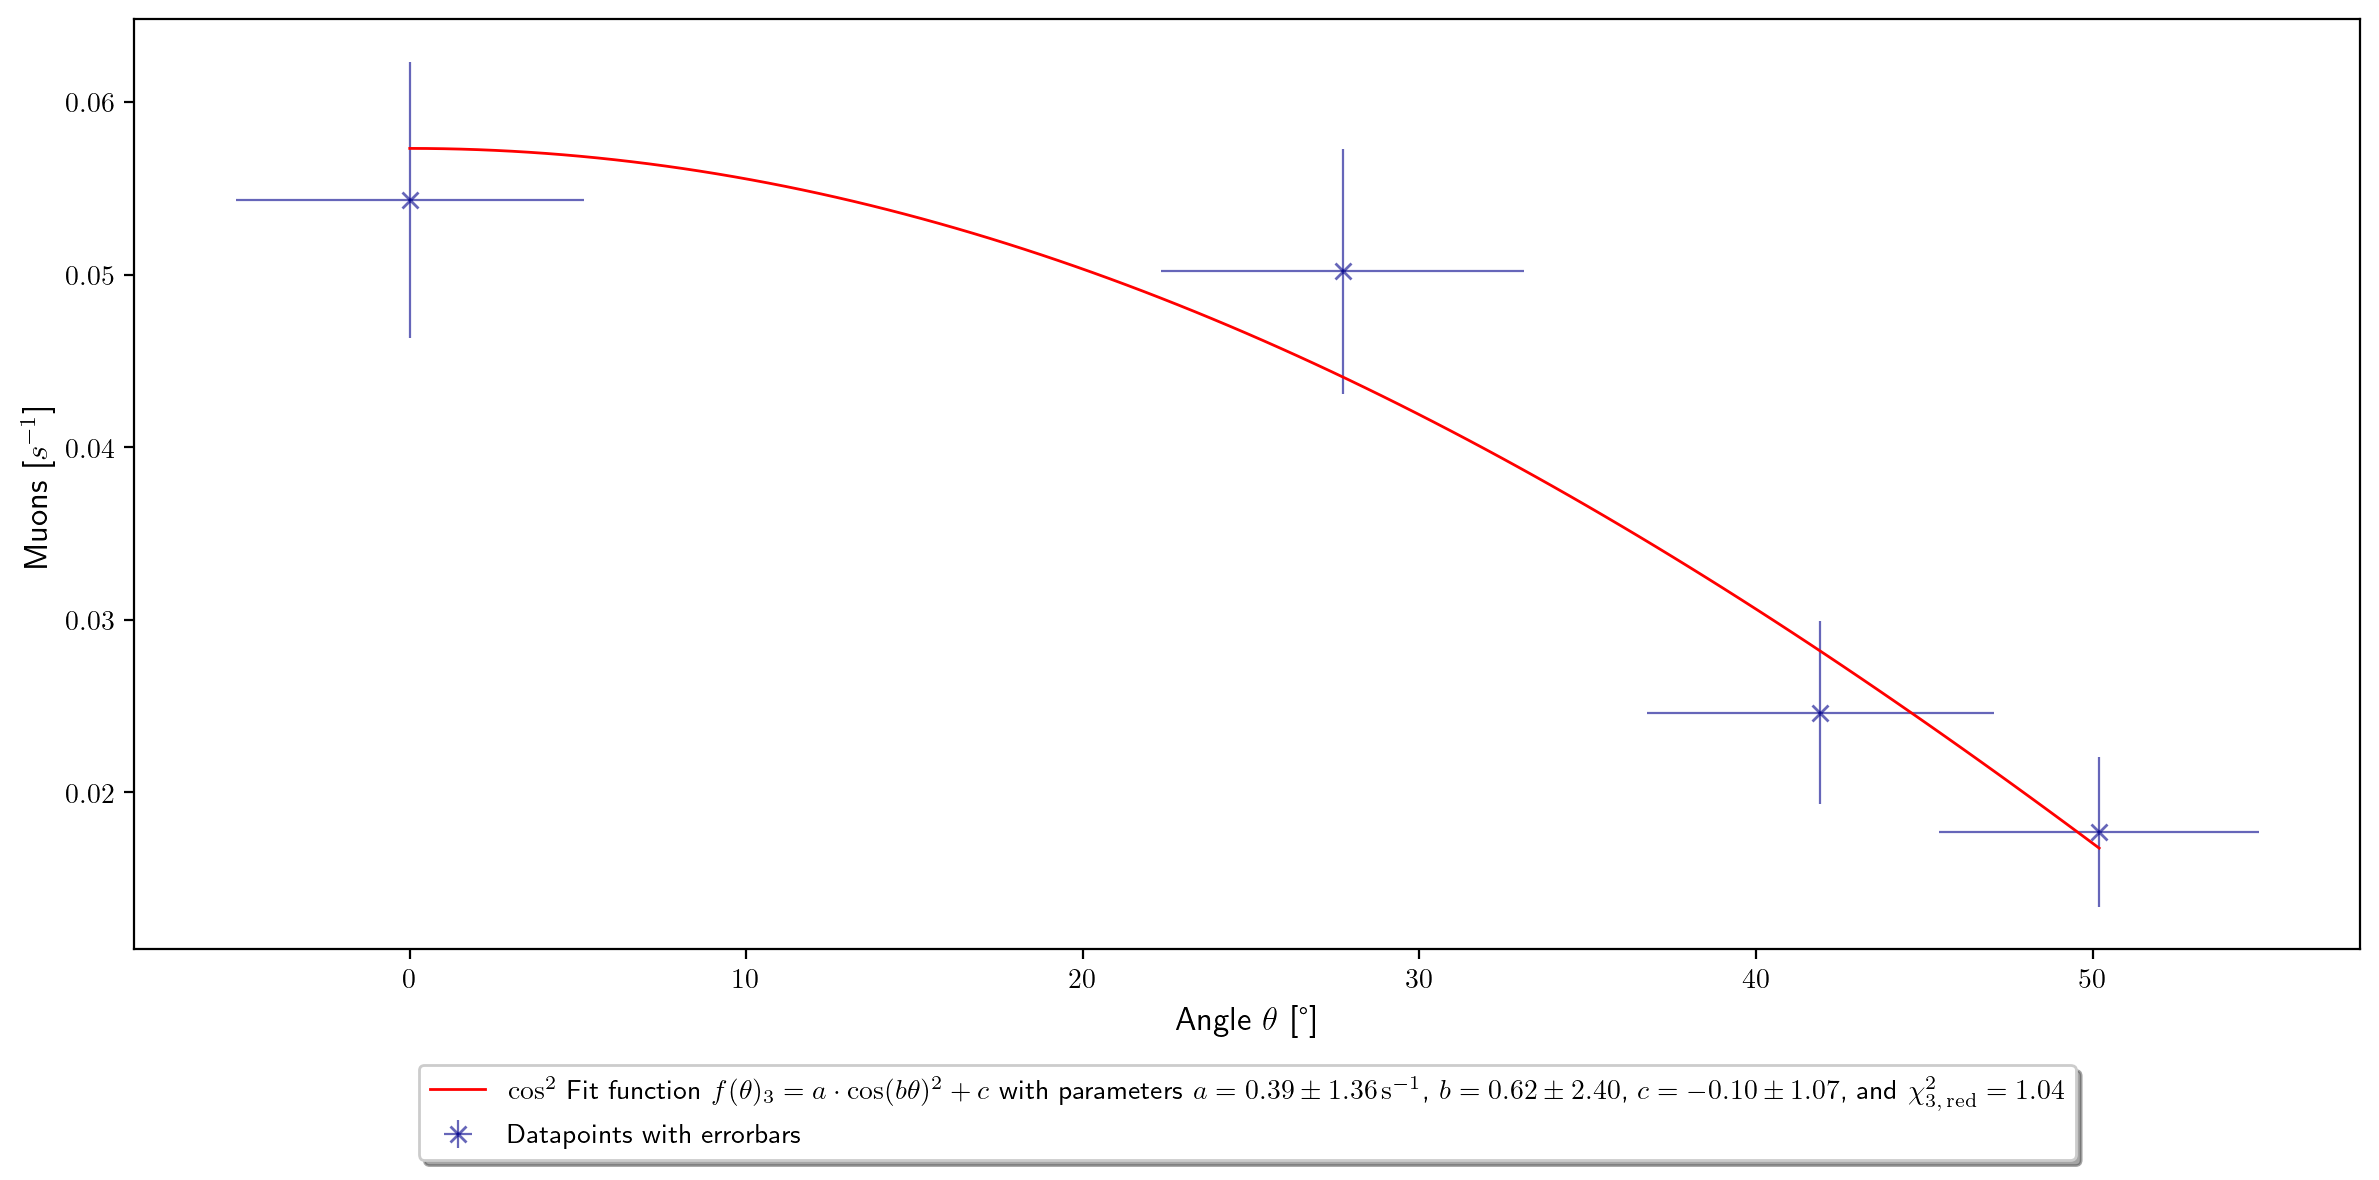

In [34]:
#Fit with cos^2 of muons respective to angle:

def model_f(x,a,b,c):
    return ((a*np.cos(b*np.pi*x/180))**2+c)

# a is: Initial rate, b is: Scaling, c is: Offset

popt, pcov = curve_fit(model_f, angledegr, countrate,sigma = countrateerr, p0=[1,1,0], maxfev=16000)
perr = np.sqrt(np.diag(pcov))

a_opt, b_opt, c_opt = popt
x_model = np.linspace(min(angledegr), max(angledegr), 100)
y_model = model_f(x_model, a_opt, b_opt, c_opt)

print('a =',a_opt,'±',np.sqrt(pcov[0,0]),', b =',b_opt,'±',np.sqrt(pcov[1,1]),', c =',c_opt,'±',np.sqrt(pcov[2,2]))

#Calculating chi2

N = len(countrate)
k = len(popt)
nu = N - k

angledegr = np.array(angledegr)
countrate = np.array(countrate)
angledegrerror = np.array(angledegrerror)
countrateerr = np.array(countrateerr)

dydx = b_opt * np.exp(-a_opt / np.cos(np.pi*angledegr / 180)) * (a_opt * np.sin(np.pi*angledegr / 180) / (180 * np.cos(np.pi*angledegr / 180)**2))
sigma = np.sqrt(countrateerr**2 + (dydx**2) * angledegrerror**2)

chi2 = np.sum(((countrate - model_f(angledegr,*popt)) / sigma)**2)
print((countrate - model_f(angledegr,*popt)))
chi2_red = chi2 / nu
print('nu', nu)
print('chi2',chi2)
print('chi2_red',chi2_red)

#Plot of the values as errorbar, with fit function

fig = plt.figure(figsize=(12, 6), dpi=200)
plt.errorbar(angledegr,countrate,countrateerr,angledegrerror, fmt='x', color='darkblue', alpha=0.6, linewidth=0.8,label="Data")
plt.plot(x_model,y_model,'-', color='red', lw=1.0,)
plt.xlabel(r"Angle $\theta$ [°]", fontsize=12)
plt.ylabel(r"Muons [$s^{-1}$]", fontsize=12)
plt.legend([
    r'$\cos^2$ Fit function $f(\theta)_3 = a \cdot \cos(b \theta)^2 + c$ '
    r'with parameters $a = 0.39 \pm 1.36\,\mathrm{s}^{-1}$, '
    r'$b = 0.62 \pm 2.40$, '
    r'$c = -0.10 \pm 1.07$, '
    r'and $\chi^2_{3,\,\mathrm{red}} = 1.04$',
    'Datapoints with errorbars'
],
loc='upper center', bbox_to_anchor=(0.5, -0.11),
fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("Subtask3_squarefit_measuredrate.pdf")
plt.savefig("Aufgabe3.pdf", dpi=600, bbox_inches = "tight")